In [1]:
import torch
from PIL import Image
from torchvision.transforms import v2
import torchvision.transforms as v1
from torch import nn
import numpy as np
from tqdm import tqdm
import random
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import wandb
import albumentations as A
from math import ceil

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Patching and merging

In [2]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transforms=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transforms = transforms

    def __len__(self):
        return len(self.slices_ids)

    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = Image.open(img_path)
        msk = Image.open(msk_path)
        img = np.array(img, dtype=np.float32)
        msk = np.array(msk)

        if self.transforms is not None:
            t = self.transforms(image=img, mask=msk)
            img = t["image"]
            msk = t["mask"]
            
        img = torch.from_numpy(img)[None, :]
        msk = torch.as_tensor(msk, dtype=torch.float32)
        # img = img / img.max()
        # msk /= 255 

        return img, msk
        
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = sorted(os.listdir(imgs_dir))
patch_size = 224
transforms = A.Compose(
    [
        A.RandomCrop(patch_size, patch_size)
    ]
)

train_ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
    transforms=transforms,
)

eval_ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
)

print("Train Dataset length:", len(train_ds))
print("Eval Dataset length:", len(eval_ds))

train_dl = DataLoader(
    train_ds,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False,
    persistent_workers=True
)

eval_dl = DataLoader(
    eval_ds,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False,
    persistent_workers=True
)

print("Train DataLoader length:", len(train_dl))
print("Eval DataLoader length:", len(eval_dl))

Train Dataset length: 2279
Eval Dataset length: 2279
Train DataLoader length: 72
Eval DataLoader length: 72


In [3]:
x, y = next(iter(eval_dl))
print("Batch shape:", x.shape)
print(x.dtype)

torch.Size([32, 1, 1303, 912])
torch.float32


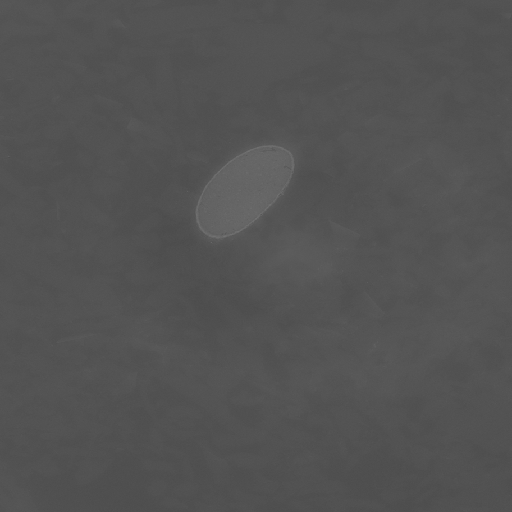

In [4]:
idx = 31
Image.fromarray(x[idx].squeeze().numpy().astype(np.uint16)).resize((512, 512))

In [5]:
h, w = x.shape[-2:]
overlap = 50
stride = patch_size - overlap

x = F.pad(
    x,
    (0, stride * ceil((w - patch_size) / stride) + patch_size - w, 0, stride * ceil((h - patch_size) / stride) + patch_size - h),
    mode="reflect"
)

h_pad, w_pad = x.shape[-2:]
print("Height + padding:", h_pad)
print("Width + padding:", w_pad)

Height + padding: 1442
Width + padding: 920


In [6]:
unfold = torch.nn.Unfold(
    kernel_size=(patch_size, patch_size),
    stride=patch_size - overlap
)

fold = torch.nn.Fold(
    output_size=(h_pad, w_pad),
    kernel_size=(patch_size, patch_size),
    stride=patch_size - overlap
)


In [7]:
average_mask = (1 / fold(unfold(torch.ones(1, h_pad, w_pad))))
average_mask.shape

torch.Size([1, 1442, 920])

In [8]:
patches = unfold(x).view(32, patch_size, patch_size, -1).permute(0, 3, 1, 2)
patches.shape

torch.Size([32, 40, 224, 224])

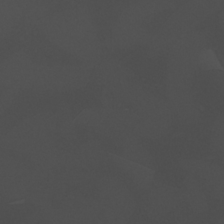

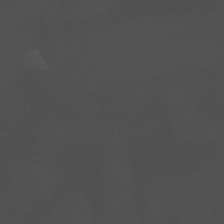

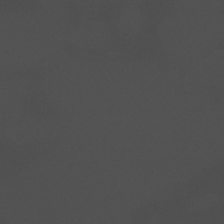

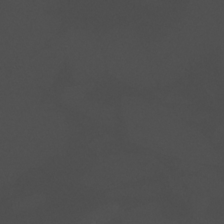

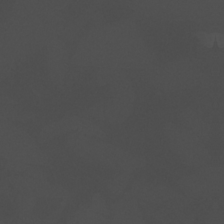

In [9]:
for i in range(5):
    display(Image.fromarray(patches[idx][i].numpy().astype(np.uint16)))

In [10]:
x_restored = fold(patches.permute(0, 2, 3, 1).view(32, patch_size * patch_size, -1))
x_restored = x_restored * average_mask
x_restored = x_restored[:, :, :h, :w]
x_restored.shape


torch.Size([32, 1, 1303, 912])

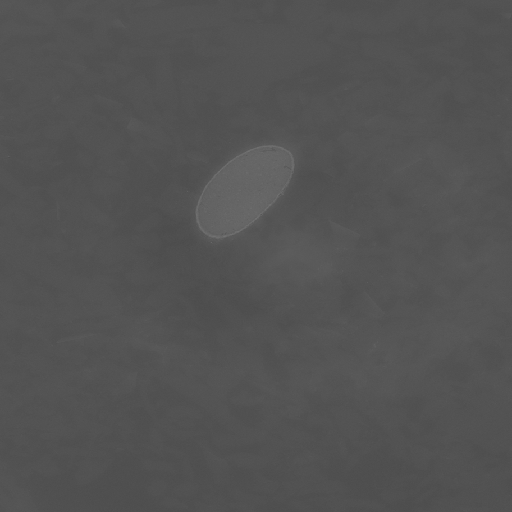

In [11]:
Image.fromarray(x_restored[idx].squeeze().numpy().astype(np.uint16)).resize((512, 512))

### Testing with the model

In [12]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transforms=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transforms = transforms

    def __len__(self):
        return len(self.slices_ids)

    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = Image.open(img_path)
        msk = Image.open(msk_path)
        img = np.array(img, dtype=np.float32)
        msk = np.array(msk)

        if self.transforms is not None:
            t = self.transforms(image=img, mask=msk)
            img = t["image"]
            msk = t["mask"]
            
        img = torch.from_numpy(img)[None, :]
        msk = torch.as_tensor(msk, dtype=torch.float32)
        # img = img / img.max()
        # msk /= 255 

        return img, msk
        
patch_size = 224
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = sorted(os.listdir(imgs_dir))

transforms = A.Compose(
    [
        A.RandomCrop(patch_size, patch_size)
    ]
)

train_ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
    transforms=transforms,
)

eval_ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
)

print("Train Dataset length:", len(train_ds))
print("Eval Dataset length:", len(eval_ds))

train_dl = DataLoader(
    train_ds,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False,
    persistent_workers=True
)

eval_dl = DataLoader(
    eval_ds,
    batch_size=4,
    num_workers=os.cpu_count(),
    shuffle=False,
    persistent_workers=True
)

print("Train DataLoader length:", len(train_dl))
print("Eval DataLoader length:", len(eval_dl))

Train Dataset length: 2279
Eval Dataset length: 2279
Train DataLoader length: 72
Eval DataLoader length: 570


In [13]:
x, y = next(iter(eval_dl))
x, y = x.to(device), y.to(device)
print(x.shape)
print(y.shape)

torch.Size([4, 1, 1303, 912])
torch.Size([4, 1303, 912])


In [14]:
import segmentation_models_pytorch as smp

net = smp.Unet(
    encoder_name="timm-mobilenetv3_small_075",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
net.to(device)
print(f"Number of params: {sum([p.nelement() for p in net.parameters()]):,}")

Number of params: 2,881,625


In [15]:
class Patcher:
    def __init__(self, h, w, patch_size, overlap):
        self.h = h
        self.w = w
        self.patch_size = patch_size
        self.overlap = overlap

        self.stride = patch_size - overlap
        self.h_pad = self.stride * ceil((h - patch_size) / self.stride) + patch_size - h
        self.w_pad = self.stride * ceil((w - patch_size) / self.stride) + patch_size - w

        self.unfold = torch.nn.Unfold(
            kernel_size=(patch_size, patch_size),
            stride=self.stride
        )
        self.fold = torch.nn.Fold(
            output_size=(h + self.h_pad, w + self.w_pad),
            kernel_size=(patch_size, patch_size),
            stride=self.stride
        )

    def extract_patches(self, x):
        bs = len(x)
        x = F.pad(x, (0, self.w_pad, 0, self.h_pad), mode="reflect")
        patches = self.unfold(x).view(bs, self.patch_size, self.patch_size, -1).permute(0, 3, 1, 2)
        return patches
    
    def merge_patches(self, patches):
        bs = len(patches)
        average_mask = (1 / self.fold(self.unfold(torch.ones(1, self.h + self.h_pad, self.w + self.w_pad, device=patches.device))))

        x_restored = self.fold(patches.permute(0, 2, 3, 1).view(bs, self.patch_size * self.patch_size, -1))
        x_restored = x_restored * average_mask
        x_restored = x_restored[:, :, :self.h, :self.w]

        return x_restored


In [16]:
# no padding needed
patcher = Patcher(10, 10, patch_size=4, overlap=2)
patcher.h_pad, patcher.w_pad

(0, 0)

In [17]:
bs, c, h, w = x.shape
overlap = 50
patcher = Patcher(h, w, patch_size=patch_size, overlap=overlap)
print("Height:", h)
print("Width:", w)

Height: 1303
Width: 912


In [18]:
with torch.no_grad():
    x, y = x.to(device), y.to(device)
    x = patcher.extract_patches(x)   # (bs, n_patches, patch_size, patch_size)
    print("patches tensor shape:", x.shape)

    x = x.reshape(-1, 1, patch_size, patch_size)          # (bs * n_patches, 1, patch_size, patch_size)
    print(x.shape)
    logits = net(x)                                       # (bs * n_patches, 1, patch_size, patch_size)
    print(logits.shape)
    logits = logits.view(bs, -1, patch_size, patch_size)  # (bs, n_patches, patch_size, patch_size) 
    print(logits.shape)
    logits = patcher.merge_patches(logits).squeeze()      # (bs, h, w)

    print("logits shape:", logits.shape)


patches tensor shape: torch.Size([4, 40, 224, 224])
torch.Size([160, 1, 224, 224])
torch.Size([160, 1, 224, 224])
torch.Size([4, 40, 224, 224])
logits shape: torch.Size([4, 1303, 912])


In [19]:
torch.nn.functional.binary_cross_entropy_with_logits(logits, y)

tensor(0.6647, device='cuda:0')